### 데이콘 중고차 가격 예측 Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import re
import optuna
from optuna.integration import XGBoostPruningCallback
sns.set_theme(style="darkgrid")


## Data Load

In [2]:
preprocess_X = pd.read_csv('preprocessed_data//preprocess_X_data.csv',index_col=0)
preprocess_Y = pd.read_csv('preprocessed_data//preprocess_Y_data.csv',index_col=0) 

In [3]:
preprocess_X

,Year_prd,Year_model,Brand,Model,Mileage,CC,Fuel_CNG,Fuel_Diesel,Fuel_Gasoline,Fuel_Hybrid,Fuel_LPG
0,2018,2014,16,47,85231,999,0,0,1,0,0
1,2010,2006,17,20,135000,1598,0,0,1,0,0
2,2002,2002,9,36,255223,1796,0,0,1,0,0
3,2006,2001,11,133,238000,2184,0,1,0,0,0
4,2007,2007,3,25,251000,1910,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
57915,2017,2011,9,23,64839,1461,0,1,0,0,0
57916,2006,2005,12,142,299850,1796,0,0,1,0,0
57917,2013,2003,3,90,112000,1368,0,0,1,0,0
57918,2006,2004,12,19,189321,1598,0,0,1,0,0


In [4]:
preprocess_Y

,Price
0,51.74
1,41.47
2,17.81
3,18.20
4,17.55
...,...
57915,116.87
57916,15.47
57917,21.97
57918,16.77


In [5]:
train_df = preprocess_X.merge(preprocess_Y, how='left', left_index=True, right_index=True)
test_df = pd.read_csv('test.csv') 
# df = df[df['주행거리'] != df['주행거리'].max()]

## Preprocessing

In [6]:
def columns_toENG(Data):
    
    print("[Preprocessing] def columns_toENG...")
    Data = Data.rename(columns={'생산년도':'Year_prd','모델출시년도':'Year_model','브랜드':'Brand','차량모델명':'Model','판매도시':'City','판매구역':'Area'})
    Data = Data.rename(columns={'주행거리':'Mileage','배기량':'CC','압축천연가스(CNG)':'Fuel_CNG','경유':'Fuel_Diesel','가솔린':'Fuel_Gasoline','하이브리드':'Fuel_Hybrid','액화석유가스(LPG)':'Fuel_LPG','가격':'Price'})

    return Data

test_df = columns_toENG(test_df)
test_df

[Preprocessing] def columns_toENG...


,ID,Year_prd,Year_model,Brand,Model,City,Area,Mileage,CC,Fuel_CNG,Fuel_Diesel,Fuel_Gasoline,Fuel_Hybrid,Fuel_LPG
0,TEST_00000,2017,2013,mazda,3,KAL,WIE,57000,1998,0,0,1,0,0
1,TEST_00001,2011,2008,ford,fiesta,ROP,POD,159000,1242,0,0,1,0,0
2,TEST_00002,2019,2017,volkswagen,polo,LOD,LOD,11284,999,0,0,1,0,0
3,TEST_00003,2021,2016,renault,megane,JAW,SLA,9,1332,0,0,1,0,0
4,TEST_00004,2010,2011,volvo,v60,WEJ,POM,270000,1999,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14475,TEST_14475,2012,2008,honda,jazz,PIA,MAZ,77405,1339,0,0,1,0,0
14476,TEST_14476,2011,2008,renault,kangoo,MJU,POM,228559,1461,0,1,0,0,0
14477,TEST_14477,2018,2012,toyota,auris,POO,DOL,17412,1798,0,0,0,1,0
14478,TEST_14478,2017,2008,renault,megane,WAR,MAZ,193000,1461,0,1,0,0,0


In [7]:
def drop_features(Data,needless_columns):

    print("[Preprocessing] def drop_features...")
    
    for i in needless_columns:
        Data = Data.drop(columns = i)
    return Data

# needless_columns : 필요없는 컬럼 제거

needless_columns = [['ID'], ['City'], ['Area']]

test_df = drop_features(test_df,needless_columns)

[Preprocessing] def drop_features...


In [8]:
test_df

,Year_prd,Year_model,Brand,Model,Mileage,CC,Fuel_CNG,Fuel_Diesel,Fuel_Gasoline,Fuel_Hybrid,Fuel_LPG
0,2017,2013,mazda,3,57000,1998,0,0,1,0,0
1,2011,2008,ford,fiesta,159000,1242,0,0,1,0,0
2,2019,2017,volkswagen,polo,11284,999,0,0,1,0,0
3,2021,2016,renault,megane,9,1332,0,0,1,0,0
4,2010,2011,volvo,v60,270000,1999,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
14475,2012,2008,honda,jazz,77405,1339,0,0,1,0,0
14476,2011,2008,renault,kangoo,228559,1461,0,1,0,0,0
14477,2018,2012,toyota,auris,17412,1798,0,0,0,1,0
14478,2017,2008,renault,megane,193000,1461,0,1,0,0,0


In [9]:
# Object 형 (ID 제외) -> Int 형 
def format_features(Data):
    
    print("[Preprocessing] def format_features...")
    from sklearn.preprocessing import LabelEncoder

    Data_dtypes = dict(Data.dtypes)

    for column,dtype in Data_dtypes.items():

        # ID 제외 dtype 이 문자형인 column Label Encoding
        if dtype == 'object':
            if column != 'ID':
                le = LabelEncoder()
                le = le.fit(Data[column])
                print("-------------------------------------------------------")
                print("column : ", column)
                print(le.classes_ )
                Data[column] = le.transform(Data[column])

    return Data

test_df= format_features(test_df)
test_df

[Preprocessing] def format_features...
-------------------------------------------------------
column :  Brand
['audi' 'bmw' 'citroen' 'fiat' 'ford' 'honda' 'hyundai' 'kia' 'mazda'
 'mercedes-benz' 'mitsubishi' 'nissan' 'opel' 'peugeot' 'renault' 'seat'
 'skoda' 'toyota' 'volkswagen' 'volvo']
-------------------------------------------------------
column :  Model
['2' '3' '3008' '5' '5008' '6' '80' 'a-klasa' 'a3' 'a4' 'a5' 'a6'
 'a6-allroad' 'a7' 'a8' 'accord' 'agila' 'alhambra' 'almera' 'astra'
 'auris' 'avensis' 'aygo' 'b-klasa' 'berlingo' 'bravo' 'c-klasa' 'c-max'
 'c4-picasso' 'c5' 'caddy' 'carens' 'ceed' 'civic' 'cl-klasa' 'clio'
 'clk-klasa' 'cls-klasa' 'colt' 'combo' 'corolla' 'corsa' 'cr-v' 'doblo'
 'e-klasa' 'elantra' 'espace' 'fabia' 'fiesta' 'focus' 'frontera' 'galaxy'
 'gl-klasa' 'golf' 'grand-scenic' 'hr-v' 'i10' 'i20' 'i30' 'ibiza'
 'insignia' 'jazz' 'jetta' 'juke' 'ka' 'kangoo' 'kuga' 'laguna' 'lancer'
 'land-cruiser' 'leon' 'm-klasa' 'megane' 'meriva' 'micra' 'mondeo' '

,Year_prd,Year_model,Brand,Model,Mileage,CC,Fuel_CNG,Fuel_Diesel,Fuel_Gasoline,Fuel_Hybrid,Fuel_LPG
0,2017,2013,8,1,57000,1998,0,0,1,0,0
1,2011,2008,4,48,159000,1242,0,0,1,0,0
2,2019,2017,18,85,11284,999,0,0,1,0,0
3,2021,2016,14,72,9,1332,0,0,1,0,0
4,2010,2011,19,127,270000,1999,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
14475,2012,2008,5,61,77405,1339,0,0,1,0,0
14476,2011,2008,14,65,228559,1461,0,1,0,0,0
14477,2018,2012,17,20,17412,1798,0,0,0,1,0
14478,2017,2008,14,72,193000,1461,0,1,0,0,0


## Modeling

In [10]:
train_X = pd.read_csv('preprocessed_data//preprocess_X_data.csv',index_col=0)
train_y  = pd.read_csv('preprocessed_data//preprocess_Y_data.csv',index_col=0) 
print(train_X.shape, train_y.shape)

(56699, 11) (56699, 1)


In [11]:
from sklearn.metrics import mean_absolute_error

def MAE(y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    return mae

def mae_cv(model):
    tscv = TimeSeriesSplit(n_splits=10)
    mae_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mae = MAE(y_test, pred) 
        mae_list.append(mae)
    return model_name, mae_list

def print_mae_score(model):
    model_name, score = mae_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAE: {r:.4f}')
    print(f'\n{model_name} mean MAE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)


## 모델 정의

In [12]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

reg = LinearRegression(n_jobs=-1)
ridge = Ridge(alpha=0.8, random_state=1)
lasso = Lasso(alpha = 0.01, random_state=1)
Enet = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)
DTree = DecisionTreeRegressor(max_depth=6, min_samples_split=10, min_samples_leaf=15, random_state=1)
rf = RandomForestRegressor(n_estimators=500, criterion='squared_error', max_depth=9, min_samples_split=50,
                           min_samples_leaf=5, random_state=1, n_jobs=-1)

model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=9, min_child_weight=5, gamma=0.1, n_jobs=-1)
model_lgb = lgb.LGBMRegressor(n_estimators=500, max_depth=9, min_child_weight=5, n_jobs=-1)

## 학습을 시키고 성능을 테스트합니다.


In [13]:
models = []
scores = []
for model in [reg, ridge, lasso, Enet, DTree, rf, model_xgb, model_lgb]:
    model_name, mean_score = print_mae_score(model)
    models.append(model_name)
    scores.append(mean_score)

LinearRegression Cross Validations...: 100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 88.40it/s]


1 FOLDS: LinearRegression MAE: 13.4507
2 FOLDS: LinearRegression MAE: 13.3399
3 FOLDS: LinearRegression MAE: 13.5496
4 FOLDS: LinearRegression MAE: 13.2124
5 FOLDS: LinearRegression MAE: 13.2905
6 FOLDS: LinearRegression MAE: 13.2262
7 FOLDS: LinearRegression MAE: 13.3155
8 FOLDS: LinearRegression MAE: 13.0787
9 FOLDS: LinearRegression MAE: 13.0557
10 FOLDS: LinearRegression MAE: 13.1368

LinearRegression mean MAE: 13.2656


Ridge Cross Validations...: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 155.39it/s]


1 FOLDS: Ridge MAE: 13.4497
2 FOLDS: Ridge MAE: 13.3397
3 FOLDS: Ridge MAE: 13.5496
4 FOLDS: Ridge MAE: 13.2126
5 FOLDS: Ridge MAE: 13.2904
6 FOLDS: Ridge MAE: 13.2263
7 FOLDS: Ridge MAE: 13.3156
8 FOLDS: Ridge MAE: 13.0787
9 FOLDS: Ridge MAE: 13.0559
10 FOLDS: Ridge MAE: 13.1368

Ridge mean MAE: 13.2655


Lasso Cross Validations...: 100%|██████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.16it/s]


1 FOLDS: Lasso MAE: 13.4450
2 FOLDS: Lasso MAE: 13.3401
3 FOLDS: Lasso MAE: 13.5519
4 FOLDS: Lasso MAE: 13.2168
5 FOLDS: Lasso MAE: 13.2906
6 FOLDS: Lasso MAE: 13.2258
7 FOLDS: Lasso MAE: 13.3174
8 FOLDS: Lasso MAE: 13.0793
9 FOLDS: Lasso MAE: 13.0598
10 FOLDS: Lasso MAE: 13.1392

Lasso mean MAE: 13.2666


ElasticNet Cross Validations...: 100%|█████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.44it/s]


1 FOLDS: ElasticNet MAE: 13.4561
2 FOLDS: ElasticNet MAE: 13.3619
3 FOLDS: ElasticNet MAE: 13.5847
4 FOLDS: ElasticNet MAE: 13.2592
5 FOLDS: ElasticNet MAE: 13.3262
6 FOLDS: ElasticNet MAE: 13.2491
7 FOLDS: ElasticNet MAE: 13.3489
8 FOLDS: ElasticNet MAE: 13.0973
9 FOLDS: ElasticNet MAE: 13.0876
10 FOLDS: ElasticNet MAE: 13.1540

ElasticNet mean MAE: 13.2925


DecisionTreeRegressor Cross Validations...: 100%|██████████████████████████████████████| 10/10 [00:00<00:00, 27.88it/s]


1 FOLDS: DecisionTreeRegressor MAE: 11.3220
2 FOLDS: DecisionTreeRegressor MAE: 11.0609
3 FOLDS: DecisionTreeRegressor MAE: 10.9135
4 FOLDS: DecisionTreeRegressor MAE: 10.7233
5 FOLDS: DecisionTreeRegressor MAE: 10.8468
6 FOLDS: DecisionTreeRegressor MAE: 10.5325
7 FOLDS: DecisionTreeRegressor MAE: 10.8609
8 FOLDS: DecisionTreeRegressor MAE: 10.9538
9 FOLDS: DecisionTreeRegressor MAE: 10.8273
10 FOLDS: DecisionTreeRegressor MAE: 10.7393

DecisionTreeRegressor mean MAE: 10.8780


RandomForestRegressor Cross Validations...:   0%|                                               | 0/10 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_14352\1690838155.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = model.fit(X_train, y_train)
RandomForestRegressor Cross Validations...:  10%|███▉                                   | 1/10 [00:00<00:05,  1.57it/s]C:\Users\user\AppData\Local\Temp\ipykernel_14352\1690838155.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = model.fit(X_train, y_train)
RandomForestRegressor Cross Validations...:  20%|███████▊                               | 2/10 [00:01<00:06,  1.28it/s]C:\Users\user\AppData\Local\Temp\ipykernel_14352\1690838155.py:14: DataConversionWarning: A column-vector y was passed when a 1

1 FOLDS: RandomForestRegressor MAE: 9.1107
2 FOLDS: RandomForestRegressor MAE: 8.5543
3 FOLDS: RandomForestRegressor MAE: 8.3209
4 FOLDS: RandomForestRegressor MAE: 8.0511
5 FOLDS: RandomForestRegressor MAE: 8.1891
6 FOLDS: RandomForestRegressor MAE: 7.8874
7 FOLDS: RandomForestRegressor MAE: 7.9828
8 FOLDS: RandomForestRegressor MAE: 8.0185
9 FOLDS: RandomForestRegressor MAE: 7.8861
10 FOLDS: RandomForestRegressor MAE: 7.9808

RandomForestRegressor mean MAE: 8.1982


XGBRegressor Cross Validations...: 100%|███████████████████████████████████████████████| 10/10 [00:41<00:00,  4.11s/it]


1 FOLDS: XGBRegressor MAE: 7.9166
2 FOLDS: XGBRegressor MAE: 7.3782
3 FOLDS: XGBRegressor MAE: 7.2481
4 FOLDS: XGBRegressor MAE: 6.8832
5 FOLDS: XGBRegressor MAE: 6.7201
6 FOLDS: XGBRegressor MAE: 6.4284
7 FOLDS: XGBRegressor MAE: 6.2332
8 FOLDS: XGBRegressor MAE: 6.3183
9 FOLDS: XGBRegressor MAE: 6.2117
10 FOLDS: XGBRegressor MAE: 6.3897

XGBRegressor mean MAE: 6.7728


LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 10/10 [00:04<00:00,  2.31it/s]

1 FOLDS: LGBMRegressor MAE: 7.2150
2 FOLDS: LGBMRegressor MAE: 6.4610
3 FOLDS: LGBMRegressor MAE: 6.4123
4 FOLDS: LGBMRegressor MAE: 6.2100
5 FOLDS: LGBMRegressor MAE: 6.1549
6 FOLDS: LGBMRegressor MAE: 5.8349
7 FOLDS: LGBMRegressor MAE: 5.8853
8 FOLDS: LGBMRegressor MAE: 5.8995
9 FOLDS: LGBMRegressor MAE: 5.7738
10 FOLDS: LGBMRegressor MAE: 5.9135

LGBMRegressor mean MAE: 6.1760


In [14]:
result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df

,Model,Score
0,LinearRegression,13.265601
1,Ridge,13.265539
2,Lasso,13.266606
3,ElasticNet,13.292500
4,DecisionTreeRegressor,10.878023
5,RandomForestRegressor,8.198167
6,XGBRegressor,6.772765
7,LGBMRegressor,6.176031


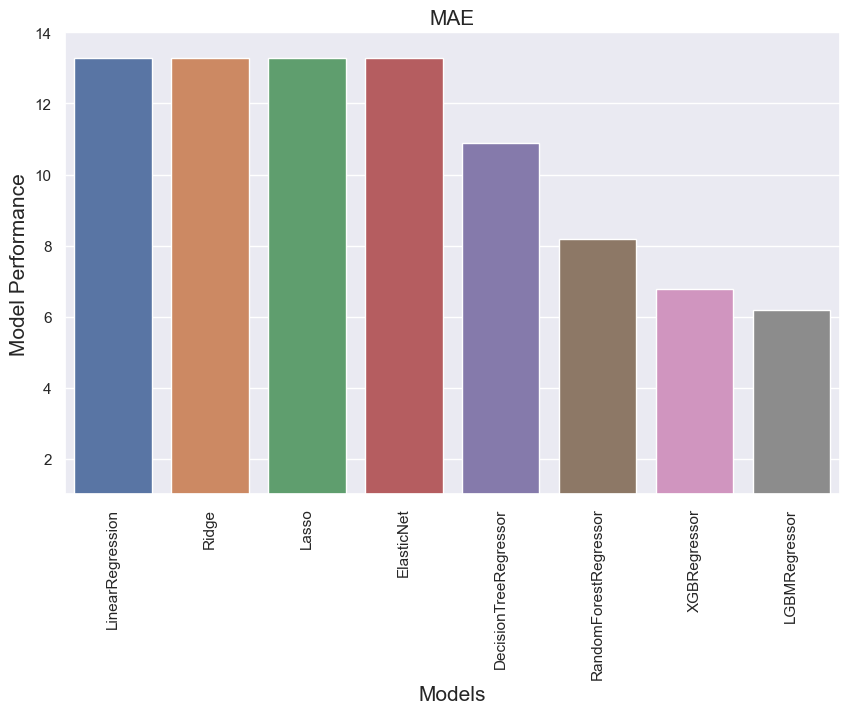

In [15]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=90)
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(1,14)
plt.title('MAE', fontsize=15)
plt.show()

- CV 결과 LightGBM의 평균 MAE가 6.176031로 가장 작은 것을 알 수 있습니다.
- LightGBM을 이용하여 하이퍼 파라미터 튜닝을 진행하겠습니다.

## Hyperparameter Tuning

In [16]:
cut = int(len(train_df)*0.8)
h_train = train_df[:cut]
h_valid = train_df[cut:]

h_train_X = h_train.drop('Price', axis=1)
h_train_y = h_train['Price']
h_valid_X = h_valid.drop('Price', axis=1)
h_valid_y = h_valid['Price']
print(h_train_X.shape, h_train_y.shape, h_valid_X.shape, h_valid_y.shape)

(45359, 11) (45359,) (11340, 11) (11340,)


In [17]:
h_train_X.head()

,Year_prd,Year_model,Brand,Model,Mileage,CC,Fuel_CNG,Fuel_Diesel,Fuel_Gasoline,Fuel_Hybrid,Fuel_LPG
0,2018,2014,16,47,85231,999,0,0,1,0,0
1,2010,2006,17,20,135000,1598,0,0,1,0,0
2,2002,2002,9,36,255223,1796,0,0,1,0,0
3,2006,2001,11,133,238000,2184,0,1,0,0,0
4,2007,2007,3,25,251000,1910,0,1,0,0,0


In [18]:
dtrain = xgb.DMatrix(h_train_X, label=h_train_y)
dtrain

- XGBoost

In [32]:
from sklearn.metrics import mean_absolute_error

def objective(trial):
    dtrain = xgb.DMatrix(h_train_X, label=h_train_y)
    dtest = xgb.DMatrix(h_valid_X, label=h_valid_y)

    param = {
        'objective': 'reg:squarederror', # 회귀
#         'verbose': -1,
#         'metric': 'mae', 
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = xgb.XGBRegressor(**param)
    xgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0, early_stopping_rounds=25)
    predictions = xgb_model.predict(h_valid_X)
    mae = mean_absolute_error(h_valid_y, predictions)
    return mae

study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb.optimize(objective, n_trials=100)


[I 2023-06-20 13:53:46,124] A new study created in memory with name: no-name-e01af093-b1c7-4f42-869a-eae190b385e0
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_

[I 2023-06-20 13:57:58,533] Trial 6 finished with value: 47.31671885812514 and parameters: {'max_depth': 8, 'learning_rate': 4.299969611433686e-05, 'n_estimators': 1589, 'subsample': 0.6917722111652806}. Best is trial 0 with value: 6.015653693364832.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-packages\xgboost\sklearn.py

[I 2023-06-20 14:01:50,088] Trial 13 finished with value: 37.805634109718675 and parameters: {'max_depth': 12, 'learning_rate': 0.0007464163797484689, 'n_estimators': 398, 'subsample': 0.8113329518140231}. Best is trial 12 with value: 6.004465142053272.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-packages\xgboost\sklearn

[I 2023-06-20 14:05:12,094] Trial 20 finished with value: 41.447712031349305 and parameters: {'max_depth': 11, 'learning_rate': 0.00020592187269775217, 'n_estimators': 986, 'subsample': 0.9268663412543098}. Best is trial 15 with value: 5.980908297701067.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-packages\xgboost\sklear

[I 2023-06-20 14:15:02,658] Trial 27 finished with value: 6.0575092038704605 and parameters: {'max_depth': 11, 'learning_rate': 0.0022140110964096313, 'n_estimators': 1930, 'subsample': 0.9887183287026196}. Best is trial 26 with value: 5.946580683175849.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-packages\xgboost\sklear

[I 2023-06-20 14:30:34,504] Trial 34 finished with value: 9.759475655913985 and parameters: {'max_depth': 10, 'learning_rate': 0.0007201260834365236, 'n_estimators': 2573, 'subsample': 0.9396957316914176}. Best is trial 30 with value: 5.885282637598652.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-packages\xgboost\sklearn

[I 2023-06-20 14:41:06,861] Trial 41 finished with value: 5.960799854017859 and parameters: {'max_depth': 9, 'learning_rate': 0.0036901979269287092, 'n_estimators': 2130, 'subsample': 0.9427747385867656}. Best is trial 37 with value: 5.868059385810159.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-packages\xgboost\sklearn.

[I 2023-06-20 14:52:13,076] Trial 48 finished with value: 9.866889443680094 and parameters: {'max_depth': 11, 'learning_rate': 0.0008058428055694459, 'n_estimators': 2264, 'subsample': 0.9487822401213731}. Best is trial 37 with value: 5.868059385810159.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-packages\xgboost\sklearn

[I 2023-06-20 14:58:54,290] Trial 55 finished with value: 5.871974949683673 and parameters: {'max_depth': 9, 'learning_rate': 0.009655669045741217, 'n_estimators': 2684, 'subsample': 0.8779872282899401}. Best is trial 37 with value: 5.868059385810159.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-packages\xgboost\sklearn.p

[I 2023-06-20 15:04:00,363] Trial 62 finished with value: 5.990870109897653 and parameters: {'max_depth': 6, 'learning_rate': 0.008525056772697066, 'n_estimators': 2821, 'subsample': 0.7894773819234988}. Best is trial 59 with value: 5.86525610963401.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-packages\xgboost\sklearn.py

[I 2023-06-20 15:08:59,124] Trial 69 finished with value: 5.972107348166235 and parameters: {'max_depth': 9, 'learning_rate': 0.0027179600599536715, 'n_estimators': 2503, 'subsample': 0.8058421847640972}. Best is trial 59 with value: 5.86525610963401.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-packages\xgboost\sklearn.p

[I 2023-06-20 15:16:55,124] Trial 76 finished with value: 5.895054519480078 and parameters: {'max_depth': 8, 'learning_rate': 0.005707371136860387, 'n_estimators': 2923, 'subsample': 0.8208166333222068}. Best is trial 71 with value: 5.855751108426056.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-packages\xgboost\sklearn.p

[I 2023-06-20 15:23:05,863] Trial 83 finished with value: 5.867292039863647 and parameters: {'max_depth': 11, 'learning_rate': 0.005385852006988908, 'n_estimators': 2375, 'subsample': 0.733245389014203}. Best is trial 71 with value: 5.855751108426056.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-packages\xgboost\sklearn.p

[I 2023-06-20 15:32:06,459] Trial 90 finished with value: 5.869878832469752 and parameters: {'max_depth': 11, 'learning_rate': 0.004217255332944124, 'n_estimators': 2404, 'subsample': 0.7807261170676879}. Best is trial 71 with value: 5.855751108426056.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-packages\xgboost\sklearn.

[I 2023-06-20 15:39:15,110] Trial 97 finished with value: 6.013902942556553 and parameters: {'max_depth': 12, 'learning_rate': 0.0016343814215986946, 'n_estimators': 2377, 'subsample': 0.6748408158099456}. Best is trial 71 with value: 5.855751108426056.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1402179058.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-packages\xgboost\sklearn

### xgb 하이퍼 파라미터 튜닝

In [22]:
from sklearn.metrics import mean_absolute_error
from optuna.samplers import TPESampler
sampler = TPESampler(seed=10)
def objective(trial):
    dtrain = xgb.DMatrix(h_train_X, label=h_train_y)
    dtest = xgb.DMatrix(h_valid_X, label=h_valid_y)

    param = {
        'objective': 'reg:squarederror',  # regression
#         'verbose': -1,
#         'metric': 'mae',
        'max_depth': trial.suggest_int('max_depth', 3, 25),  # Modify the upper bound of max_depth
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-10, 1e-2),  # Modify the lower bound of learning_rate
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),  # Modify the upper bound of n_estimators
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),  # Modify the upper bound of min_child_samples
        'subsample': trial.suggest_loguniform('subsample', 0.4, 0.9),  # Modify the upper bound of subsample
    }

    model = xgb.XGBRegressor(**param)
    xgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0, early_stopping_rounds=25)
    predictions = xgb_model.predict(h_valid_X)
    mae = mean_absolute_error(h_valid_y, predictions)
    return mae

study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb.optimize(objective, n_trials=100)




[I 2023-06-20 09:15:09,875] A new study created in memory with name: no-name-3f59fffc-df43-44c2-be20-475d8f36c23e
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-10, 1e-2),  # Modify the lower bound of learning_rate
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 0.9),  # Modify the upper bound of subsample
C:\Users\user\miniconda3\envs\py\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` 

[I 2023-06-20 09:33:48,112] Trial 6 finished with value: 50.533929334780105 and parameters: {'max_depth': 13, 'learning_rate': 2.965595722907862e-07, 'n_estimators': 6216, 'subsample': 0.6064266935655814}. Best is trial 3 with value: 50.11403986867563.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-10, 1e-2),  # Modify the lower bound of learning_rate
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 0.9),  # Modify the upper b

[I 2023-06-20 09:42:30,976] Trial 13 finished with value: 5.887320000656067 and parameters: {'max_depth': 9, 'learning_rate': 0.0069189139312508295, 'n_estimators': 3795, 'subsample': 0.4040405401173955}. Best is trial 12 with value: 5.854634707997506.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-10, 1e-2),  # Modify the lower bound of learning_rate
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 0.9),  # Modify the upper b

[I 2023-06-20 09:51:32,393] Trial 20 finished with value: 13.218756388571737 and parameters: {'max_depth': 3, 'learning_rate': 0.0003154199364677076, 'n_estimators': 5358, 'subsample': 0.45913565915637355}. Best is trial 12 with value: 5.854634707997506.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-10, 1e-2),  # Modify the lower bound of learning_rate
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 0.9),  # Modify the upper

[I 2023-06-20 10:03:48,030] Trial 27 finished with value: 48.81009800943643 and parameters: {'max_depth': 7, 'learning_rate': 1.1812017529955223e-05, 'n_estimators': 3123, 'subsample': 0.4342407835262624}. Best is trial 12 with value: 5.854634707997506.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-10, 1e-2),  # Modify the lower bound of learning_rate
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 0.9),  # Modify the upper 

[I 2023-06-20 10:22:03,163] Trial 34 finished with value: 5.929479241806783 and parameters: {'max_depth': 10, 'learning_rate': 0.0029453845822872936, 'n_estimators': 2071, 'subsample': 0.4377633000706284}. Best is trial 12 with value: 5.854634707997506.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-10, 1e-2),  # Modify the lower bound of learning_rate
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 0.9),  # Modify the upper 

[I 2023-06-20 10:31:59,622] Trial 41 finished with value: 5.852798692518231 and parameters: {'max_depth': 11, 'learning_rate': 0.003116909763570479, 'n_estimators': 7786, 'subsample': 0.44528491628761896}. Best is trial 41 with value: 5.852798692518231.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-10, 1e-2),  # Modify the lower bound of learning_rate
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 0.9),  # Modify the upper 

[I 2023-06-20 10:53:40,956] Trial 48 finished with value: 5.873510169068762 and parameters: {'max_depth': 9, 'learning_rate': 0.003887068669629543, 'n_estimators': 6501, 'subsample': 0.45136420372458036}. Best is trial 41 with value: 5.852798692518231.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-10, 1e-2),  # Modify the lower bound of learning_rate
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 0.9),  # Modify the upper b

[I 2023-06-20 11:05:58,833] Trial 55 finished with value: 37.8094979998607 and parameters: {'max_depth': 13, 'learning_rate': 0.00037899044740360657, 'n_estimators': 786, 'subsample': 0.5221578679002774}. Best is trial 41 with value: 5.852798692518231.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-10, 1e-2),  # Modify the lower bound of learning_rate
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 0.9),  # Modify the upper b

[I 2023-06-20 11:24:02,714] Trial 62 finished with value: 5.85547763338543 and parameters: {'max_depth': 12, 'learning_rate': 0.006186469372875158, 'n_estimators': 3733, 'subsample': 0.47856992730735254}. Best is trial 41 with value: 5.852798692518231.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-10, 1e-2),  # Modify the lower bound of learning_rate
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 0.9),  # Modify the upper b

[I 2023-06-20 11:36:13,500] Trial 69 finished with value: 5.8582414964864284 and parameters: {'max_depth': 11, 'learning_rate': 0.0026121223288725266, 'n_estimators': 3775, 'subsample': 0.41415837940382194}. Best is trial 41 with value: 5.852798692518231.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-10, 1e-2),  # Modify the lower bound of learning_rate
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 0.9),  # Modify the uppe

[I 2023-06-20 11:47:30,744] Trial 76 finished with value: 8.258642076808517 and parameters: {'max_depth': 11, 'learning_rate': 0.0006673916735931987, 'n_estimators': 3235, 'subsample': 0.4823084049098073}. Best is trial 41 with value: 5.852798692518231.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-10, 1e-2),  # Modify the lower bound of learning_rate
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 0.9),  # Modify the upper 

[I 2023-06-20 11:55:15,475] Trial 83 finished with value: 5.883804492648527 and parameters: {'max_depth': 7, 'learning_rate': 0.004361725972642559, 'n_estimators': 6183, 'subsample': 0.5303945253323205}. Best is trial 41 with value: 5.852798692518231.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-10, 1e-2),  # Modify the lower bound of learning_rate
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 0.9),  # Modify the upper bo

[I 2023-06-20 12:24:23,091] Trial 90 finished with value: 5.855804240818797 and parameters: {'max_depth': 12, 'learning_rate': 0.0010842503040689147, 'n_estimators': 6992, 'subsample': 0.5081043653205418}. Best is trial 84 with value: 5.852519929680666.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-10, 1e-2),  # Modify the lower bound of learning_rate
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 0.9),  # Modify the upper 

[I 2023-06-20 12:46:16,605] Trial 97 finished with value: 6.073837411472617 and parameters: {'max_depth': 6, 'learning_rate': 0.0032639396158465873, 'n_estimators': 6611, 'subsample': 0.4904343428915909}. Best is trial 84 with value: 5.852519929680666.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-10, 1e-2),  # Modify the lower bound of learning_rate
C:\Users\user\AppData\Local\Temp\ipykernel_14352\3720291791.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 0.9),  # Modify the upper b

In [23]:
dtrain = xgb.DMatrix(h_train_X, label=h_train_y)
dtrain

- xgboost

In [24]:
trial = study_xgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 5.852519929680666,
params {'max_depth': 12, 'learning_rate': 0.00163825027614111, 'n_estimators': 7893, 'subsample': 0.4936543113687545}


In [33]:
trial = study_xgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 5.855751108426056,
params {'max_depth': 8, 'learning_rate': 0.006455411195700747, 'n_estimators': 2884, 'subsample': 0.785557133185679}


- LGBM

In [25]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)

def objective(trial):
    dtrain = lgb.Dataset(h_train_X, label=h_train_y)
    dtest = lgb.Dataset(h_valid_X, label=h_valid_y)

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'mae', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0, early_stopping_rounds=25)
    mae = MAE(h_valid_y, lgb_model.predict(h_valid_X))
    return mae
        
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2023-06-20 13:10:07,485] A new study created in memory with name: no-name-e5c6d30f-e38c-4655-a67e-b5d40fd4fab0
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopp

[I 2023-06-20 13:10:41,452] Trial 4 finished with value: 27.992856885739055 and parameters: {'max_depth': 10, 'learning_rate': 7.128863277996207e-08, 'n_estimators': 1183, 'min_child_samples': 69, 'subsample': 0.5996296351455978}. Best is trial 2 with value: 17.936377863309684.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site

[I 2023-06-20 13:11:36,429] Trial 9 finished with value: 27.95708362525757 and parameters: {'max_depth': 12, 'learning_rate': 5.967195151630884e-07, 'n_estimators': 2664, 'min_child_samples': 36, 'subsample': 0.46529289303849874}. Best is trial 2 with value: 17.936377863309684.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site

[I 2023-06-20 13:11:42,427] Trial 14 finished with value: 19.531689744513567 and parameters: {'max_depth': 15, 'learning_rate': 0.0007953098131062786, 'n_estimators': 579, 'min_child_samples': 59, 'subsample': 0.8787981219847805}. Best is trial 13 with value: 9.174759993170838.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site

[I 2023-06-20 13:12:00,003] Trial 19 finished with value: 9.929975420808178 and parameters: {'max_depth': 3, 'learning_rate': 0.00936078035561635, 'n_estimators': 385, 'min_child_samples': 81, 'subsample': 0.9267915036418815}. Best is trial 13 with value: 9.174759993170838.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-pac

[I 2023-06-20 13:12:41,482] Trial 24 finished with value: 7.669193497825771 and parameters: {'max_depth': 8, 'learning_rate': 0.0019805068575622043, 'n_estimators': 2072, 'min_child_samples': 100, 'subsample': 0.8010660322173186}. Best is trial 24 with value: 7.669193497825771.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site

[I 2023-06-20 13:13:33,938] Trial 29 finished with value: 14.792829973768812 and parameters: {'max_depth': 6, 'learning_rate': 0.0004576553844928165, 'n_estimators': 1980, 'min_child_samples': 73, 'subsample': 0.7111759738045452}. Best is trial 25 with value: 7.36476928371086.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-

[I 2023-06-20 13:14:39,614] Trial 34 finished with value: 6.4388561150986945 and parameters: {'max_depth': 9, 'learning_rate': 0.004901956601980959, 'n_estimators': 2401, 'min_child_samples': 81, 'subsample': 0.8508667688313208}. Best is trial 34 with value: 6.4388561150986945.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site

[I 2023-06-20 13:15:50,156] Trial 39 finished with value: 8.2287816205815 and parameters: {'max_depth': 11, 'learning_rate': 0.0011021063462552413, 'n_estimators': 2828, 'min_child_samples': 67, 'subsample': 0.7243725612300178}. Best is trial 37 with value: 6.385528548610717.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-p

[I 2023-06-20 13:16:54,010] Trial 44 finished with value: 6.303489171332824 and parameters: {'max_depth': 14, 'learning_rate': 0.005557686155090451, 'n_estimators': 2571, 'min_child_samples': 63, 'subsample': 0.6651713636823614}. Best is trial 44 with value: 6.303489171332824.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-

[I 2023-06-20 13:17:53,645] Trial 49 finished with value: 6.199333958265602 and parameters: {'max_depth': 14, 'learning_rate': 0.007527585665128011, 'n_estimators': 2256, 'min_child_samples': 62, 'subsample': 0.6068958877335147}. Best is trial 48 with value: 6.049631952261945.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-

[I 2023-06-20 13:18:46,871] Trial 54 finished with value: 6.139228050073605 and parameters: {'max_depth': 15, 'learning_rate': 0.009803190826449017, 'n_estimators': 1953, 'min_child_samples': 42, 'subsample': 0.5445921404664688}. Best is trial 48 with value: 6.049631952261945.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-

[I 2023-06-20 13:19:34,218] Trial 59 finished with value: 6.362843551302637 and parameters: {'max_depth': 13, 'learning_rate': 0.008530582479244512, 'n_estimators': 1422, 'min_child_samples': 31, 'subsample': 0.577378482658405}. Best is trial 48 with value: 6.049631952261945.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-p

[I 2023-06-20 13:20:28,961] Trial 64 finished with value: 6.061304331839093 and parameters: {'max_depth': 12, 'learning_rate': 0.009862528717604844, 'n_estimators': 2319, 'min_child_samples': 46, 'subsample': 0.6275351125608893}. Best is trial 48 with value: 6.049631952261945.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-

[I 2023-06-20 13:21:30,010] Trial 69 finished with value: 6.057064308151999 and parameters: {'max_depth': 15, 'learning_rate': 0.009870810827601292, 'n_estimators': 2338, 'min_child_samples': 44, 'subsample': 0.6220058216079808}. Best is trial 48 with value: 6.049631952261945.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-

[I 2023-06-20 13:22:28,742] Trial 74 finished with value: 6.244053705298796 and parameters: {'max_depth': 15, 'learning_rate': 0.0060728094016779905, 'n_estimators': 2487, 'min_child_samples': 48, 'subsample': 0.6191163622052708}. Best is trial 48 with value: 6.049631952261945.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site

[I 2023-06-20 13:23:34,655] Trial 79 finished with value: 6.740414627604815 and parameters: {'max_depth': 13, 'learning_rate': 0.0026940792272121886, 'n_estimators': 2783, 'min_child_samples': 26, 'subsample': 0.6220377508057306}. Best is trial 78 with value: 5.9835752642743785.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\sit

[I 2023-06-20 13:24:39,778] Trial 84 finished with value: 5.991047716542346 and parameters: {'max_depth': 13, 'learning_rate': 0.009770674696647576, 'n_estimators': 2675, 'min_child_samples': 36, 'subsample': 0.6449273038417317}. Best is trial 78 with value: 5.9835752642743785.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site

[I 2023-06-20 13:25:51,377] Trial 89 finished with value: 6.328876239900053 and parameters: {'max_depth': 14, 'learning_rate': 0.00471378504776075, 'n_estimators': 2776, 'min_child_samples': 39, 'subsample': 0.6478397538760607}. Best is trial 78 with value: 5.9835752642743785.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-

[I 2023-06-20 13:26:52,763] Trial 94 finished with value: 6.40842674484207 and parameters: {'max_depth': 13, 'learning_rate': 0.004432525704763289, 'n_estimators': 2564, 'min_child_samples': 43, 'subsample': 0.642697520769579}. Best is trial 78 with value: 5.9835752642743785.
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
C:\Users\user\AppData\Local\Temp\ipykernel_14352\1727959256.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
C:\Users\user\miniconda3\envs\py\Lib\site-p

[I 2023-06-20 13:27:54,373] Trial 99 finished with value: 6.445590051245386 and parameters: {'max_depth': 14, 'learning_rate': 0.0038001543620383256, 'n_estimators': 2844, 'min_child_samples': 37, 'subsample': 0.5884008026661525}. Best is trial 96 with value: 5.972606383062698.


- LightGBM

In [27]:
trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 5.972606383062698,
params {'max_depth': 15, 'learning_rate': 0.009984291961728292, 'n_estimators': 2837, 'min_child_samples': 39, 'subsample': 0.614660774100875}


### 모델 컬럼 Drop 전 모델링 결과
- Best Trial: score 5.999950959945952,
params {'max_depth': 14, 'learning_rate': 0.009991417077230875, 'n_estimators': 2762, 'min_child_samples': 63, 'subsample': 0.6620062972540173}

### https://dacon.io/en/codeshare/2876

In [ ]:
train_df.head()

In [ ]:
test_df.head()

In [29]:
# LGBM
final_lgb_model = lgb.LGBMRegressor(**trial_params)
final_lgb_model.fit(train_X, train_y)
final_lgb_pred = final_lgb_model.predict(test_df)

In [ ]:
final_xgb_model

In [34]:
# xgboost
final_xgb_model = xgb.XGBRegressor(**trial_params)
final_xgb_model.fit(train_X, train_y)
final_xgb_pred = final_xgb_model.predict(test_df)

In [ ]:
final_xgb_pred

In [ ]:
final_lgb_pred

<BarContainer object of 11 artists>

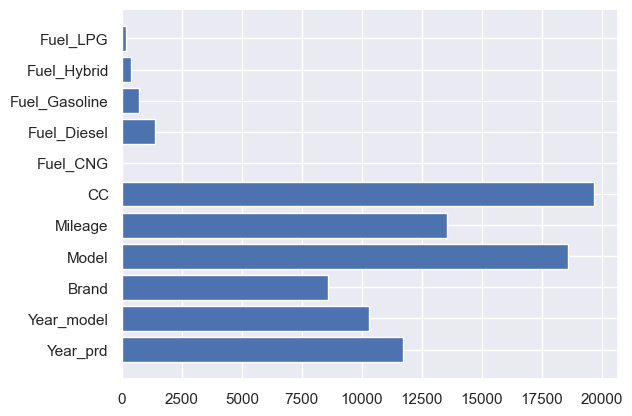

In [30]:
plt.barh(train_X.columns, final_lgb_model.feature_importances_)

<BarContainer object of 11 artists>

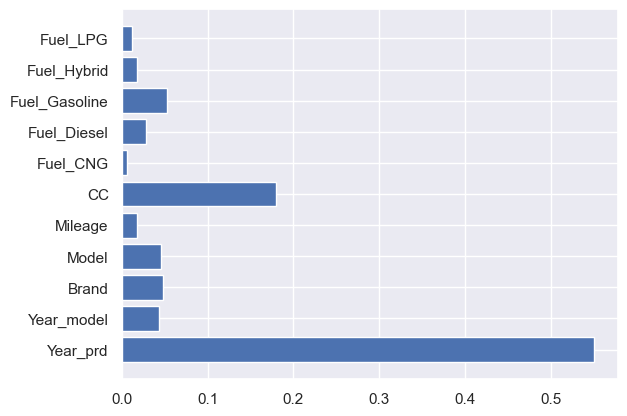

In [35]:
plt.barh(train_X.columns, final_xgb_model.feature_importances_)

### 배기량과 모델, 주행거리 순으로 중요도가 높은 것을 확인

## Submission

In [ ]:
# final_pred_sub = np.expm1(final_lgb_pred)
# final_pred_sub


In [ ]:
# sub = pd.read_csv('test.csv')
# sub_df = pd.DataFrame({'ID': sub['ID'], '가격': final_pred_sub})
# sub_df final_xgb_pred

sub = pd.read_csv('test.csv')
sub_df = pd.DataFrame({'ID': sub['ID'], '가격': final_lgb_pred})
sub_df

In [36]:
sub = pd.read_csv('test.csv')
sub_df = pd.DataFrame({'ID': sub['ID'], '가격': final_xgb_pred})
sub_df

,ID,가격
0,TEST_00000,91.078590
1,TEST_00001,24.917791
2,TEST_00002,85.753120
3,TEST_00003,113.811516
4,TEST_00004,46.418915
...,...,...
14475,TEST_14475,40.041107
14476,TEST_14476,26.238853
14477,TEST_14477,108.100090
14478,TEST_14478,52.233761


In [37]:
sub_df.to_csv('submission_xgb2.csv', index=False)

In [ ]:
# sub_df.to_csv('submission_lgb.csv', index=False)